In [50]:
import configparser
import time
import math

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.linear_model

from solml import cnn, load
from solml.training import split, get_info

In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')
roof_cache_dir = config['main']['roof_cache_dir']

## Size of images

In [3]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.two_balanced_classes()
idents = train_ids + val_ids + test_ids
bounding_boxes = get_info.get_bounding_box(idents)
images = load.load_data(idents, bounding_boxes, 5, 5, False) # download

In [4]:
N = len(idents)
print("%d images"%N)
sizes = np.zeros((N, 2))
for i, ident in enumerate(idents):
    filename = roof_cache_dir + str(ident) + '.jpg'
    image = Image.open(filename)
    x, y = image.size
    sizes[i, 0] = x
    sizes[i, 1] = y

6000 images


array([ 87.66866667,  88.42833333])

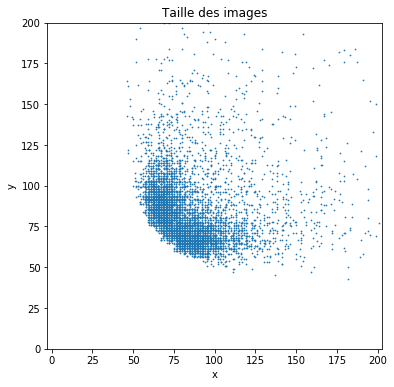

In [5]:
# plot sizes of images
plt.figure(figsize=(6, 6))
plt.scatter(sizes[:, 0], sizes[:, 1], s=0.5)
plt.axis('equal')
plt.xlim([0,200])
plt.ylim([0,200])
plt.title('Taille des images')
plt.xlabel('x')
plt.ylabel('y')
sizes.mean(axis=0)

## Use the CNN features to train a classifier

In [6]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = split.two_balanced_classes()

In [7]:
bounding_boxes = get_info.get_bounding_box(train_ids)
cnn_train = cnn.get_cnn_features_list(train_ids, bounding_boxes)

In [8]:
bounding_boxes = get_info.get_bounding_box(val_ids)
cnn_val = cnn.get_cnn_features_list(val_ids, bounding_boxes)

In [9]:
bounding_boxes = get_info.get_bounding_box(test_ids)
cnn_test = cnn.get_cnn_features_list(test_ids, bounding_boxes)

In [16]:
n_C = 20
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.131381 seconds.
LR took 0.109344 seconds.
LR took 0.108933 seconds.
LR took 0.189432 seconds.
LR took 0.250398 seconds.
LR took 0.452976 seconds.
LR took 0.772000 seconds.
LR took 1.261907 seconds.
LR took 1.531266 seconds.
LR took 1.685140 seconds.
LR took 1.599060 seconds.
LR took 1.647008 seconds.
LR took 1.627505 seconds.
LR took 1.608213 seconds.
LR took 1.608166 seconds.
LR took 1.602810 seconds.
LR took 1.584173 seconds.
LR took 1.624982 seconds.
LR took 1.632586 seconds.
LR took 1.607358 seconds.


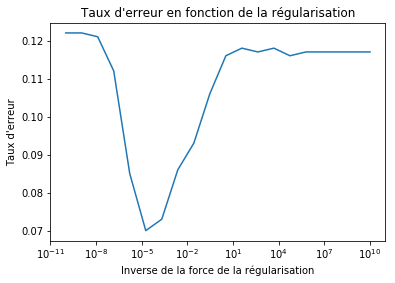

In [17]:
plt.plot(C_list, errors)
plt.title("Taux d'erreur en fonction de la régularisation")
plt.ylabel("Taux d'erreur")
plt.xlabel("Inverse de la force de la régularisation")
plt.xscale('log')

In [18]:
i_opt = np.argmin(errors)
C_opt = C_list[i_opt] #0.000018#
print('optimal C : %f'%C_opt)
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt)
t = time.time()
model.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000018
LR took 0.478891 seconds.


In [19]:
err

0.074999999999999997

In [20]:
cnn_proba_val = model.predict_proba(cnn_val)[:,0]
cnn_proba_test = model.predict_proba(cnn_test)[:,0]

## Visualize some wrong predictions

In [21]:
indexes_wrong = np.where(test_labels!=predictions)[0]

In [22]:
indexes_wrong = np.where(test_labels!=predictions)[0]
def show_wrong():
    i = np.random.choice(indexes_wrong)
    ident = test_ids[i]

    image = np.array(Image.open(roof_cache_dir + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

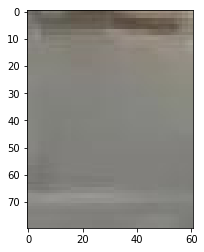

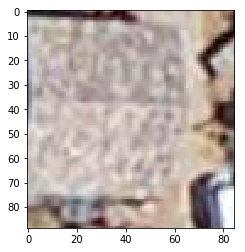

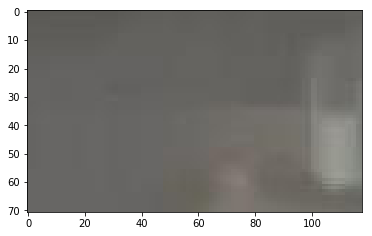

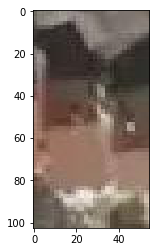

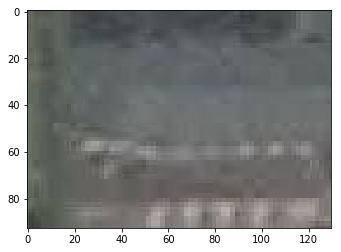

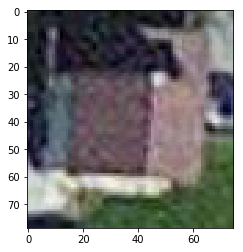

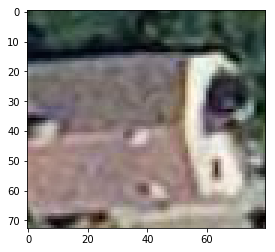

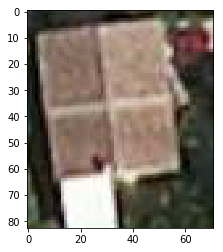

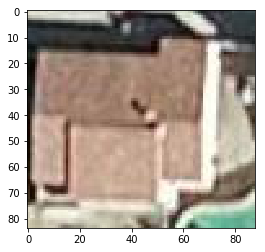

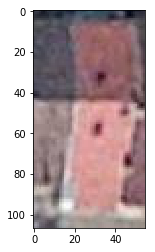

In [23]:
for i in range(10):
    show_wrong()

In [24]:
indexes_right = np.where(test_labels==predictions)[0]
def show_right():
    i = np.random.choice(indexes_right)
    ident = test_ids[i]

    image = np.array(Image.open(roof_cache_dir + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

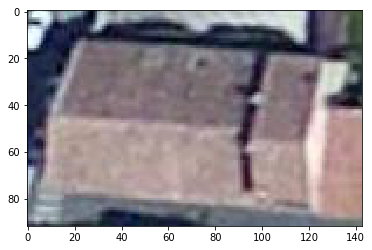

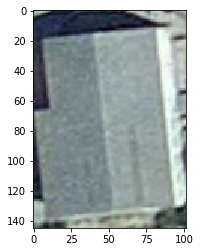

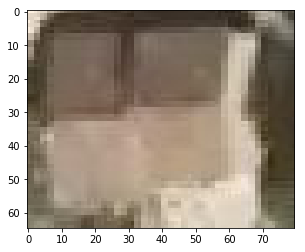

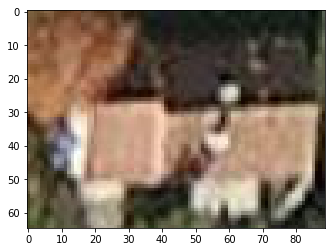

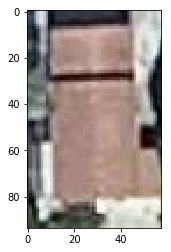

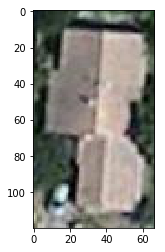

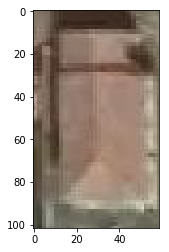

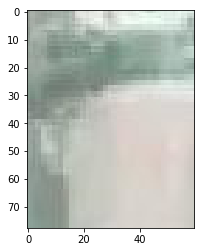

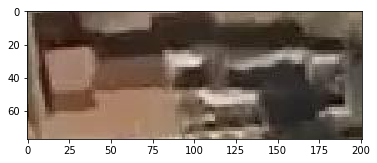

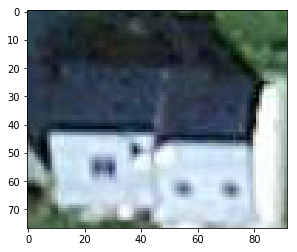

In [25]:
for i in range(10):
    show_right()

# Mix with other features

In [26]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = split.load_images(train_ids, val_ids, test_ids, l, color)

In [35]:
train_reduc = train_reduc.reshape((4000, 36))
val_reduc = val_reduc.reshape((1000, 36))
test_reduc = test_reduc.reshape((1000, 36))


In [36]:
train_ids[0]

'75937227'

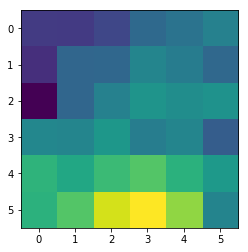

In [37]:
plt.imshow(train_reduc[0].reshape(6, 6), interpolation='none')

In [38]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(train_reduc, train_labels)
predictions = model.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.14199999999999999

In [39]:
reduc_proba_val = model.predict_proba(val_reduc)[:,0]
reduc_proba_test = model.predict_proba(test_reduc)[:,0]

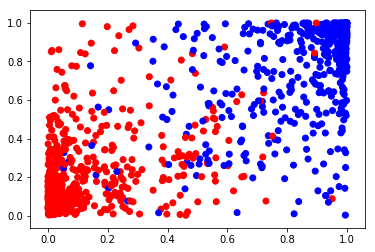

In [40]:
def colorize(labels):
    return ['b' if l==1 else 'r' for l in labels]
plt.scatter(cnn_proba_val, reduc_proba_val, c=colorize(val_labels))

In [41]:
N_val = len(reduc_proba_val)
val_mix = np.zeros((N_val, 2))
val_mix[:, 0] = cnn_proba_val
val_mix[:, 1] = reduc_proba_val
N_test = len(reduc_proba_test)
test_mix = np.zeros((N_test, 2))
test_mix[:, 0] = cnn_proba_test
test_mix[:, 1] = reduc_proba_test

In [42]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(val_mix, val_labels)
predictions = model.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.064000000000000001

In [43]:
probas = model.predict_proba(test_mix)

## Confidence

In [44]:
confidence = np.max(probas, axis=1)

(array([   4.,    1.,    0.,    3.,    0.,    2.,    1.,    4.,    0.,
           1.,    2.,    3.,    0.,    2.,    3.,    2.,    1.,    2.,
           2.,    4.,    0.,    2.,    3.,    1.,    0.,    2.,    0.,
           3.,    3.,    0.,    0.,    2.,    3.,    1.,    1.,    3.,
           1.,    1.,    1.,    4.,    2.,    3.,    2.,    3.,    3.,
           3.,    4.,    2.,    2.,    5.,    5.,    2.,    3.,    1.,
           0.,    2.,    3.,    3.,    0.,    1.,    1.,    1.,    1.,
           0.,    1.,    1.,    3.,    4.,    2.,    0.,    2.,    3.,
           3.,    3.,    5.,    3.,    3.,    7.,    9.,    5.,    7.,
           3.,    5.,    7.,   12.,    3.,    9.,    5.,   10.,   14.,
          17.,   10.,   13.,   29.,   20.,   36.,   50.,   63.,  149.,  364.]),
 array([ 0.50141708,  0.50637551,  0.51133394,  0.51629237,  0.52125081,
         0.52620924,  0.53116767,  0.5361261 ,  0.54108453,  0.54604296,
         0.5510014 ,  0.55595983,  0.56091826,  0.56587669,  0.5

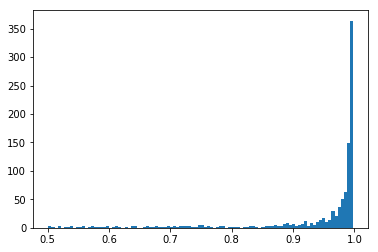

In [45]:
plt.hist(confidence, bins=100)

In [46]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N_test)

/home/michel/.virtualenvs/solar/lib/python3.4/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


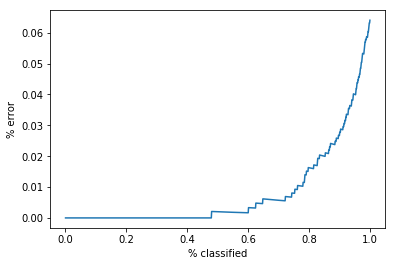

In [47]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [48]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

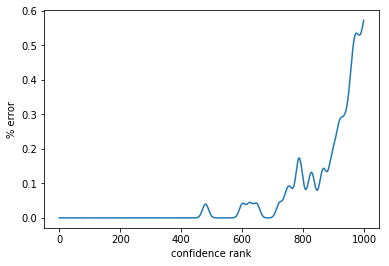

In [51]:
sigma = 10.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')